In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#models
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

#metrics
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

In [2]:
def rmse(y_test, y_pred):
    return(mse(y_test, y_pred)**0.5)

In [3]:
def model_results(y_test, y_pred):
    print('MSE score of model is {}'.format(mse(y_test, y_pred)))
    print('RMSE score of model is {}'.format(rmse(y_test, y_pred)))
    print('MAE score of model is {}'.format(mae(y_test, y_pred)))

In [4]:
data = pd.read_csv('./data/store_item_sales.csv', parse_dates=[0])

#### Data Preparation

In [5]:
data.dtypes

date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

In [6]:
data.head(3)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14


In [7]:
data.tail(3)

,date,store,item,sales
21909,2017-12-29,3,4,25
21910,2017-12-30,3,4,20
21911,2017-12-31,3,4,30


#### Descriptive Statistics

In [8]:
data.describe().drop(['store','item'], axis=1)

,sales
count,21912.000000
mean,38.646997
std,21.432825
min,3.000000
25%,23.000000
50%,33.000000
75%,50.000000
max,150.000000


#### Eda

##### 1. Total Daily Sales

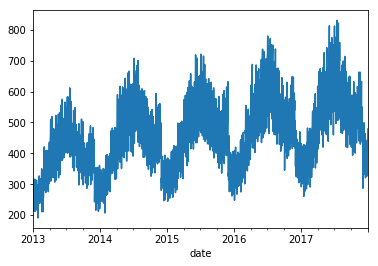

In [9]:
data.groupby(['date'])['sales'].sum().plot()

##### 2. 1st item in the 1st store

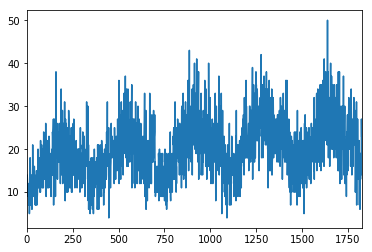

In [10]:
data[(data['item']==1) & (data['store']==1)]['sales'].plot()

#### Feature Engineering

##### 1. Date Time Features

In [11]:
data['month'] = data['date'].dt.month
data['is_month_start'] = (data.date.dt.is_month_start).astype(int)
data['is_month_end'] = (data.date.dt.is_month_end).astype(int)

data['dayofweek'] = data['date'].dt.dayofweek
data['dayofmonth'] = data['date'].dt.day
data['dayofyear'] = data.date.dt.dayofyear

data['weekofyear'] = data['date'].dt.weekofyear

##### 2. Lagged Sales Feature

In [12]:
data['lagged_sales'] = data.groupby(['store','item'])['sales'].shift(14)

##### EDA with New Features

More EDA for multistore multiproduct forecasting on this [page](https://www.kaggle.com/c/demand-forecasting-kernels-only/).

##### 1. Monthly Pattern/Seasonality

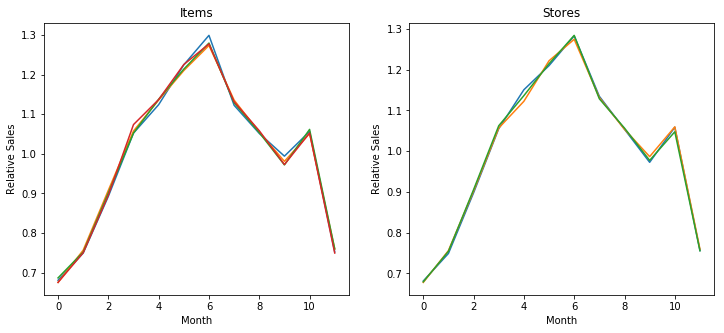

In [13]:
agg_month_item = pd.pivot_table(data, index='month', columns='item',
                                values='sales', aggfunc=np.mean).values
agg_month_store = pd.pivot_table(data, index='month', columns='store',
                                 values='sales', aggfunc=np.mean).values

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_month_item / agg_month_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Month")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_month_store / agg_month_store.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Month")
plt.ylabel("Relative Sales")
plt.show()

##### 2. Daily Pattern/Seasonality

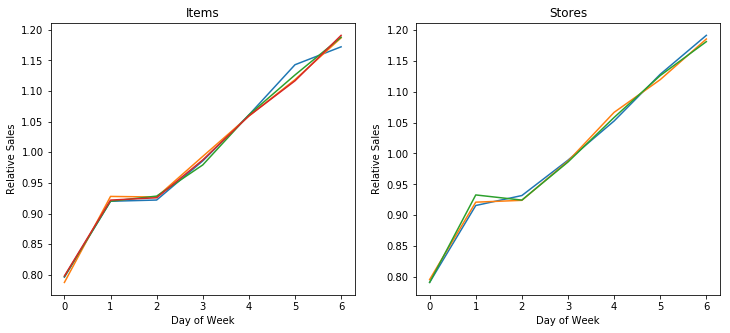

In [14]:
agg_dow_item = pd.pivot_table(data, index='dayofweek', columns='item',
                              values='sales', aggfunc=np.mean).values
agg_dow_store = pd.pivot_table(data, index='dayofweek', columns='store',
                               values='sales', aggfunc=np.mean).values

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_dow_item / agg_dow_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_dow_store / agg_dow_store.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.show()

### Model

In [15]:
categorical_columns = ['store', 'item', 'month', 'is_month_start', 'is_month_end', 'dayofweek', 'dayofmonth', 'dayofyear', 'weekofyear']

for c in categorical_columns:
    data[c] = data[c].astype('category')

In [16]:
train = data.query('date > 20131231 & date < 20170101')
test = data.query('date > 20161231')

##### Missing Values

In [17]:
print('There is {} missing values in train set'.format(train.isnull().values.sum()))

There is 0 missing values in train set


In [18]:
print('There is {} missing values in train set'.format(test.isnull().values.sum()))

There is 0 missing values in train set


##### Train Test Split

In [19]:
X_train = train.drop(['date', 'sales'], axis=1)
y_train = train['sales']
X_test = test.drop(['date', 'sales'], axis=1)
y_test = test['sales']

#### Base Model<br>

Base model with default settings.

In [20]:
regr = RandomForestRegressor(n_estimators=100, random_state=42)

regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

#### Results<br>

Here rmse score of base model is 8.32, which is less than the standard deviation value of 21.43.

In [21]:
y_pred = regr.predict(X_test)

In [22]:
model_results(y_test, y_pred)

MSE score of model is 68.38942383561644
RMSE score of model is 8.269789830196197
MAE score of model is 6.291228310502284


#### Random Search<br>

Using the random grid to search for best hyperparameters. Here no `cross validation` is needed for random forest due to [bootstraping](https://www.kaggle.com/c/titanic/discussion/10089). 

In [23]:
random_grid = {'bootstrap': [True, False],
               'max_depth': [10, 20, 30, 40, 50],
               'min_samples_split': [2, 5, 7, 9],
               'min_samples_leaf': [2, 5, 7, 9],
               'max_features': ['auto', 'sqrt', 'log2']}

In [25]:
# the base model to tune
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
                           
# Random search of parameters
# search across 150 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, 
                               param_distributions=random_grid, 
                               n_iter=150,
                               cv=2,
                               verbose=2,
                               random_state=42,
                               n_jobs = -1)
                           
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 2 folds for each of 150 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.9min finished


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                                                   oob_score=False,
                                                   random_state=42, ve

#### Results

In [26]:
rf_random.best_params_

{'min_samples_split': 7,
 'min_samples_leaf': 9,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [27]:
best_model = rf_random.best_estimator_

In [28]:
y_pred = best_model.predict(X_test)

In [29]:
model_results(y_test, y_pred)

MSE score of model is 67.65040660829774
RMSE score of model is 8.224986723897963
MAE score of model is 6.166583243044845


Here rmse score of the best model is 6.16, which is less than the rmse score of the base model.